# Requêtes Openstreetmap

 spécifique à l'API d'OSM pour récupérer nos données au format json.

Nous allons effectuer des requêtes [Openstreetmap](https://www.openstreetmap.org/) (OSM). Le [wiki](https://wiki.openstreetmap.org/wiki/Main_Page) est une ressources quasi-indispensable pour bien gérer les données issues d'OSM (c'est parfois un peu obscur de comment tout ça fonctionne).

## Données géographiques OSM


Openstreetmap connait 3 types de données : 

- les noeuds : `node` : une coordonnée
- les chemins :  `way` : une liste ordonnée de nœuds (une route ou un contours)
- les relations : `relation` : une liste ordonnée de nœuds, de chemains ou d'autres relations.

Certains objets pouvant être décrits comme des chemins ou des relations selon la personne qui a référencé l'objet :

- l'ecm est un chemin : <https://www.openstreetmap.org/way/527054532>
- le chateau de versailles une relation : <https://www.openstreetmap.org/relation/1149002>
- Marseille est une relation également : <https://www.openstreetmap.org/relation/76469>

## Requêtes

On peut effectuer des requêtes OSM directement sur le site <https://overpass-turbo.eu/> ou en utisant une API avec le site <http://overpass-api.de>.

> Il est nécessaire de bien la documentation : <https://dev.overpass-api.de/overpass-doc/fr/index.html>

1. Nous allons commencer par nous familiariser avec les requêtes directement sur le site
2. Forger nos requête avec l'API pour les utiliser dans nos représentations graphiques

### Appli web

1. Rendez vous sur le site <http://overpass-turbo.eu/>
2. Centrez la carte sur l'ecm. Gardez la cqrte petite pour ne prendre que les batiments de l'ecm
3. tapez la requête ci-après dans l'éditeur de requête et exécutez là.

```
[out:json][timeout:25];
(  node({{bbox}});   
   way({{bbox}});   
   relation({{bbox}}); 
); 

out body;
```

> Si vous prenez une carte trop grande, le site vous averira que vous avez trop de données à télécharger.

Sur la carte seuls les `node` sont représentés (en utilisant leurs données `lat` et `lon`). En regardant les données vous verrez également, au format json, les `way` et les `relations` qui n'ont pas de coordonnées par défaut.

#### selection bbox

Notre sélection se fait actuellement via la carte un utilisant le paramètre `{{bbox}}`.

On peut également choisir sa propre bbox, par exemple : 

```
(43.33863,5.4336,43.34709,5.44304)
```

Qui correspond aux coordonnées (y1,x1, y2, x2) en latitude/longitude de l'ecm.

On peut alors faire la requète suivante, indépendante de la carte du site :

```
[out:json][timeout:25];
(  node(43.33863,5.4336,43.34709,5.44304);   
   way(43.33863,5.4336,43.34709,5.44304);   
   relation(43.33863,5.4336,43.34709,5.44304); 
); 

out body;
```

> Vous pouvez trouver vos propres bbox avec le site <https://norbertrenner.de/osm/bbox.html>

#### Sélection par area

Enfin, opn peut utiliser les bornes géographique d'un `way` ou d'une `relation` pour récupérer tout ce qui'il y a à l'intérieur. Par exemple dans l'em, qui est un `way` :

<https://www.openstreetmap.org/way/527054532>

On peut utiliser le code suivant, qui transforme le way en area puis fait la recherche :

```
[out:json][timeout:25];

way(527054532) -> .b;
.b map_to_area -> .a;

(  	node(area.a);   
	way(area.a);   
	relation(area.a); 
); 
out body;
```

> Lisez la doc pour voir les différentes possiblités :
> - <https://osmlab.github.io/learnoverpass/en/docs/filters/area/>
> - <https://wiki.cartocite.fr/doku.php?id=tutoverpass:jour_9_l_instruction_map_to_area>
> - <https://wiki.openstreetmap.org/wiki/Overpass_API/Overpass_QL#Map_way/relation_to_area_(map_to_area)>

## Compter les pizzeria

Notre but sera ici de compter le nombre pizzéria marseillaises par arrondissement pour les représenter sur une carte chloroplète.

Pour délimiter Marseille, on utilisera la relation : <https://www.openstreetmap.org/relation/76469>

On ne peut pas chercher tout les éléments de Marseille, il faut restreindre aux pizzeria. Pour cela :

- on sélectionne des tags dans la recherche : <https://osmlab.github.io/learnoverpass/en/docs/filters/tag/>
- les possiboités sont énorme, voir : <https://wiki.openstreetmap.org/wiki/FR:%C3%89l%C3%A9ments_cartographiques>

### Sur le site

Sur le sire cela revient à utiliser la requête :

```
[out:json][timeout:25];

rel(76469) -> .b;
.b map_to_area -> .a;

(  	node["cuisine"~"pizza"](area.a);   
	way["cuisine"~"pizza"](area.a);   
	relation["cuisine"~"pizza"](area.a); 
); 
out body;
```

Remarquer qu'il faut que : le champ cuisine soit renseigné et qu'il contienne `"pizza"`. Au final cela ne fait pas toutes les pizzerias de Marseille (et de loin) et il manque également les camions-pizza.

### Récupérer les données

Pour l'instant, les données sont récupérées sur un site et pas dasn le notebook. On peut utiliser le module [requests](https://requests-fr.readthedocs.io/en/latest/) :

In [1]:
import requests
import json

In [4]:
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
[out:json][timeout:25];

rel(76469) -> .b;
.b map_to_area -> .a;

(  	node["cuisine"~"pizza"](area.a);   
	way["cuisine"~"pizza"](area.a);   
	relation["cuisine"~"pizza"](area.a); 
); 
out body;
"""

réponse = requests.get(overpass_url, params={'data': overpass_query})

la réponse est un [objet complexe](https://requests.readthedocs.io/en/latest/user/quickstart/#response-content). Dans notre cas, elle contient un objet json qu'il nous faut convertir en dictgionnaire python :

In [8]:
data = réponse.json()

In [7]:
# data  # attention c'est gros

Les réponses sont placées dans une liste :

In [11]:
data["elements"][:5]

[{'type': 'node',
  'id': 364622149,
  'lat': 43.2930532,
  'lon': 5.3729519,
  'tags': {'amenity': 'restaurant',
   'cuisine': 'pizza',
   'indoor_seating': 'yes',
   'name': 'Coquille',
   'outdoor_seating': 'yes'}},
 {'type': 'node',
  'id': 627616768,
  'lat': 43.338386,
  'lon': 5.407488,
  'tags': {'amenity': 'restaurant', 'cuisine': 'pizza', 'name': 'La Grotte'}},
 {'type': 'node',
  'id': 991811853,
  'lat': 43.2930076,
  'lon': 5.3867809,
  'tags': {'amenity': 'pub',
   'cuisine': 'pizza',
   'food': 'yes',
   'name': 'Chez Guy'}},
 {'type': 'node',
  'id': 1250893404,
  'lat': 43.2970084,
  'lon': 5.3717617,
  'tags': {'amenity': 'restaurant',
   'cuisine': 'pizza',
   'name': 'Le Joli Port'}},
 {'type': 'node',
  'id': 1319273248,
  'lat': 43.2955584,
  'lon': 5.3790198,
  'tags': {'amenity': 'restaurant',
   'check_date': '2023-08-16',
   'cuisine': 'pizza',
   'name': 'Chez Sauveur',
   'outdoor_seating': 'yes',
   'website': 'https://www.chezsauveur.fr/'}}]

In [ ]:
Il y a deux des trois types possible :

In [23]:
type_elements = set()
for e in data["elements"]:
    type_elements.add(e["type"])

print(type_elements)

{'way', 'node'}


In [20]:
for e in data["elements"]:
    if e["type"] == "node":
        print(json.dumps(e, indent=2))
        break

{
  "type": "node",
  "id": 364622149,
  "lat": 43.2930532,
  "lon": 5.3729519,
  "tags": {
    "amenity": "restaurant",
    "cuisine": "pizza",
    "indoor_seating": "yes",
    "name": "Coquille",
    "outdoor_seating": "yes"
  }
}


In [21]:
for e in data["elements"]:
    if e["type"] == "way":
        print(json.dumps(e, indent=2))
        break

{
  "type": "way",
  "id": 153554406,
  "nodes": [
    1661538685,
    1661537988,
    1661537682,
    1661537716,
    1661538433,
    1661538685
  ],
  "tags": {
    "amenity": "fast_food",
    "building": "yes",
    "cuisine": "pizza",
    "indoor_seating": "no",
    "name": "Pizza minute",
    "outdoor_seating": "yes",
    "phone": "+33 4 91 41 74 23",
    "source": "cadastre-dgi-fr source : Direction G\u00e9n\u00e9rale des Imp\u00f4ts - Cadastre. Mise \u00e0 jour : 2012"
  }
}


On remarque que les éléments de type `way` n'ont pas de coordonnées. Ce qui va être problématique pour la suite lorsqu'il faudra les ranger par earrondissement. Il faut refaire la requête en ajoutant un paramètre à exporter, `center` :

In [29]:
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
[out:json][timeout:25];

rel(76469) -> .b;
.b map_to_area -> .a;

(  	node["cuisine"~"pizza"](area.a);   
	way["cuisine"~"pizza"](area.a);   
	relation["cuisine"~"pizza"](area.a); 
); 
out body center;
"""

pizzerias_json_raw = requests.get(overpass_url, params={'data': overpass_query}).json()["elements"]

In [30]:
pizzerias_json_raw[:5]

[{'type': 'node',
  'id': 364622149,
  'lat': 43.2930532,
  'lon': 5.3729519,
  'tags': {'amenity': 'restaurant',
   'cuisine': 'pizza',
   'indoor_seating': 'yes',
   'name': 'Coquille',
   'outdoor_seating': 'yes'}},
 {'type': 'node',
  'id': 627616768,
  'lat': 43.338386,
  'lon': 5.407488,
  'tags': {'amenity': 'restaurant', 'cuisine': 'pizza', 'name': 'La Grotte'}},
 {'type': 'node',
  'id': 991811853,
  'lat': 43.2930076,
  'lon': 5.3867809,
  'tags': {'amenity': 'pub',
   'cuisine': 'pizza',
   'food': 'yes',
   'name': 'Chez Guy'}},
 {'type': 'node',
  'id': 1250893404,
  'lat': 43.2970084,
  'lon': 5.3717617,
  'tags': {'amenity': 'restaurant',
   'cuisine': 'pizza',
   'name': 'Le Joli Port'}},
 {'type': 'node',
  'id': 1319273248,
  'lat': 43.2955584,
  'lon': 5.3790198,
  'tags': {'amenity': 'restaurant',
   'check_date': '2023-08-16',
   'cuisine': 'pizza',
   'name': 'Chez Sauveur',
   'outdoor_seating': 'yes',
   'website': 'https://www.chezsauveur.fr/'}}]

Vérifions que l'on peut bien extraire les coordonnées de nos pizzérias :

In [31]:
for e in pizzerias_json_raw:
    if e["type"] == "node":
        print(json.dumps(e, indent=2))
        break

{
  "type": "node",
  "id": 364622149,
  "lat": 43.2930532,
  "lon": 5.3729519,
  "tags": {
    "amenity": "restaurant",
    "cuisine": "pizza",
    "indoor_seating": "yes",
    "name": "Coquille",
    "outdoor_seating": "yes"
  }
}


In [32]:
for e in pizzerias_json_raw:
    if e["type"] == "way":
        print(json.dumps(e, indent=2))
        break

{
  "type": "way",
  "id": 153554406,
  "center": {
    "lat": 43.2451205,
    "lon": 5.427373
  },
  "nodes": [
    1661538685,
    1661537988,
    1661537682,
    1661537716,
    1661538433,
    1661538685
  ],
  "tags": {
    "amenity": "fast_food",
    "building": "yes",
    "cuisine": "pizza",
    "indoor_seating": "no",
    "name": "Pizza minute",
    "outdoor_seating": "yes",
    "phone": "+33 4 91 41 74 23",
    "source": "cadastre-dgi-fr source : Direction G\u00e9n\u00e9rale des Imp\u00f4ts - Cadastre. Mise \u00e0 jour : 2012"
  }
}


On va créer nos données json on ne conservant que les coordonnées et le nom. Attention certaines pizzeria n'ont pas de nom :

In [38]:
for e in pizzerias_json_raw:
    if "name" not in e["tags"]:
        print(json.dumps(e, indent=2))

{
  "type": "node",
  "id": 3370637730,
  "lat": 43.2737355,
  "lon": 5.4141282,
  "tags": {
    "amenity": "restaurant",
    "cuisine": "pizza",
    "source": "Bing + terrain"
  }
}
{
  "type": "node",
  "id": 4430509401,
  "lat": 43.3063849,
  "lon": 5.3833163,
  "tags": {
    "amenity": "fast_food",
    "contact:city": "Marseille",
    "contact:housenumber": "84",
    "contact:postcode": "13003",
    "contact:street": "Boulevard National",
    "cuisine": "kebab;pizza"
  }
}
{
  "type": "node",
  "id": 4502532514,
  "lat": 43.2964675,
  "lon": 5.3792692,
  "tags": {
    "amenity": "fast_food",
    "cuisine": "pizza"
  }
}
{
  "type": "node",
  "id": 5070023986,
  "lat": 43.297263,
  "lon": 5.3685045,
  "tags": {
    "amenity": "restaurant",
    "cuisine": "pizza"
  }
}
{
  "type": "node",
  "id": 5586151301,
  "lat": 43.3008476,
  "lon": 5.3764189,
  "tags": {
    "amenity": "fast_food",
    "contact:housenumber": "17",
    "contact:street": "Rue Francis de Pressens\u00e9",
    "cuis

In [35]:
pizzerias_json = []
for e in pizzerias_json_raw:
    if e["type"] == "node":
        pizzerias_json.append({
            "lat": e["lat"],
            "lon": e["lon"],
            "nom": e["tags"].get("name", None)})
    else:
        pizzerias_json.append({
            "lat": e["center"]["lat"],
            "lon": e["center"]["lon"],
            "nom": e["tags"].get("name", None)})

In [37]:
pizzerias_json[:5]

[{'lat': 43.2930532, 'lon': 5.3729519, 'nom': 'Coquille'},
 {'lat': 43.338386, 'lon': 5.407488, 'nom': 'La Grotte'},
 {'lat': 43.2930076, 'lon': 5.3867809, 'nom': 'Chez Guy'},
 {'lat': 43.2970084, 'lon': 5.3717617, 'nom': 'Le Joli Port'},
 {'lat': 43.2955584, 'lon': 5.3790198, 'nom': 'Chez Sauveur'}]

Avant de créer le geodataframe, commençpns par ranger nos données dans un dataframe :

In [40]:
import pandas as pd

In [47]:
df = pd.DataFrame(pizzerias_json)

In [48]:
df

,lat,lon,nom
0,43.293053,5.372952,Coquille
1,43.338386,5.407488,La Grotte
2,43.293008,5.386781,Chez Guy
3,43.297008,5.371762,Le Joli Port
4,43.295558,5.379020,Chez Sauveur
...,...,...,...
157,43.284483,5.484267,Le Gargantua
158,43.287683,5.465219,Pizza Pierrot
159,43.327329,5.363880,None
160,43.326685,5.361067,None


On peut maintenant créer le GeoDataframe.

In [46]:
import geopandas as gpd

In [87]:
pizzerias = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs=4326)

In [89]:
pizzerias

,lat,lon,nom,geometry
0,43.293053,5.372952,Coquille,POINT (5.37295 43.29305)
1,43.338386,5.407488,La Grotte,POINT (5.40749 43.33839)
2,43.293008,5.386781,Chez Guy,POINT (5.38678 43.29301)
3,43.297008,5.371762,Le Joli Port,POINT (5.37176 43.29701)
4,43.295558,5.379020,Chez Sauveur,POINT (5.37902 43.29556)
...,...,...,...,...
157,43.284483,5.484267,Le Gargantua,POINT (5.48427 43.28448)
158,43.287683,5.465219,Pizza Pierrot,POINT (5.46522 43.28768)
159,43.327329,5.363880,None,POINT (5.36388 43.32733)
160,43.326685,5.361067,None,POINT (5.36107 43.32668)


In [88]:
pizzerias.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Il faut maintenant trouver les arrondissements de marseille et faire le comptage. On peut utiliser deux jeux de données :

- Les arrondissements disponibles depuis : <https://laprovence.carto.com/tables/arrondissements/public/map>
- les quartiers disponible depuis <https://www.data.gouv.fr/fr/datasets/quartiers-de-marseille-1/>

Prenons les quartiers de marseille

In [70]:
quartiers = gpd.read_file("https://www.data.gouv.fr/fr/datasets/r/8a8f7f54-7f91-482c-a78c-dd09d893d1b6")

In [71]:
quartiers

,DEPCO,NOM_CO,NOM_QUA,geometry
0,13201,Marseille 1er Arrondissemen,BELSUNCE,"MULTIPOLYGON (((5.38086 43.29924, 5.38087 43.2..."
1,13201,Marseille 1er Arrondissemen,CHAPITRE,"MULTIPOLYGON (((5.38525 43.29906, 5.38485 43.2..."
2,13201,Marseille 1er Arrondissemen,NOAILLES,"MULTIPOLYGON (((5.38160 43.29573, 5.38177 43.2..."
3,13201,Marseille 1er Arrondissemen,OPERA,"MULTIPOLYGON (((5.37729 43.29222, 5.37663 43.2..."
4,13201,Marseille 1er Arrondissemen,SAINT CHARLES,"MULTIPOLYGON (((5.38022 43.30141, 5.38007 43.3..."
...,...,...,...,...
106,13215,Marseille 15e Arrondissemen,LA VISTE,"MULTIPOLYGON (((5.35771 43.35337, 5.35756 43.3..."
107,13216,Marseille 16e Arrondissemen,L'ESTAQUE,"MULTIPOLYGON (((5.32691 43.36112, 5.32694 43.3..."
108,13216,Marseille 16e Arrondissemen,LES RIAUX,"MULTIPOLYGON (((5.30862 43.36508, 5.30878 43.3..."
109,13216,Marseille 16e Arrondissemen,SAINT ANDRE,"MULTIPOLYGON (((5.33997 43.34367, 5.33992 43.3..."


In [76]:
quartiers.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [90]:
pizzeria_quartier = gpd.sjoin(pizzerias, quartiers, how="inner", predicate='intersects')

In [91]:
pizzeria_quartier

,lat,lon,nom,geometry,index_right,DEPCO,NOM_CO,NOM_QUA
0,43.293053,5.372952,Coquille,POINT (5.37295 43.29305),3,13201,Marseille 1er Arrondissemen,OPERA
7,43.292943,5.373558,Le Peano,POINT (5.37356 43.29294),3,13201,Marseille 1er Arrondissemen,OPERA
26,43.292992,5.373795,O'sud,POINT (5.37379 43.29299),3,13201,Marseille 1er Arrondissemen,OPERA
49,43.292977,5.377676,La Marmite,POINT (5.37768 43.29298),3,13201,Marseille 1er Arrondissemen,OPERA
109,43.294358,5.375044,Pizzeria di Venezia,POINT (5.37504 43.29436),3,13201,Marseille 1er Arrondissemen,OPERA
...,...,...,...,...,...,...,...,...
142,43.254232,5.375217,La Grande Italia,POINT (5.37522 43.25423),35,13208,Marseille 8e Arrondissemen,BONNEVEINE
145,43.291821,5.357676,Pizza du Pharo,POINT (5.35768 43.29182),31,13207,Marseille 7e Arrondissemen,LE PHARO
155,43.276964,5.416583,Melekh A Pizza,POINT (5.41658 43.27696),56,13210,Marseille 10e Arrondissemen,PONT DE VIVAUX
156,43.264394,5.369349,La Cabane des Amis,POINT (5.36935 43.26439),39,13208,Marseille 8e Arrondissemen,LA PLAGE


In [92]:
compte = (pizzeria_quartier
             .assign(nombre=1)
             .groupby(by="NOM_QUA", as_index=False)
             .sum(numeric_only=True)
        )
compte

,NOM_QUA,lat,lon,index_right,nombre
0,BAILLE,43.284886,5.393211,18,1
1,BELLE DE MAI,173.238129,21.536482,40,4
2,BELSUNCE,86.601463,10.751752,0,2
3,BOMPARD,43.282801,5.360724,28,1
4,BONNEVEINE,129.762838,16.126179,105,3
...,...,...,...,...,...
63,SAINTE ANNE,86.528614,10.781624,86,2
64,SAINTE MARGUERITE,432.660858,54.051277,520,10
65,THIERS,43.298743,5.385189,5,1
66,VAUBAN,129.850549,16.125792,81,3


In [94]:
quartiers_compte = quartiers.merge(compte[['NOM_QUA', 'nombre']], how='inner', on='NOM_QUA')

In [95]:
quartiers_compte

,DEPCO,NOM_CO,NOM_QUA,geometry,nombre
0,13201,Marseille 1er Arrondissemen,BELSUNCE,"MULTIPOLYGON (((5.38086 43.29924, 5.38087 43.2...",2
1,13201,Marseille 1er Arrondissemen,CHAPITRE,"MULTIPOLYGON (((5.38525 43.29906, 5.38485 43.2...",3
2,13201,Marseille 1er Arrondissemen,NOAILLES,"MULTIPOLYGON (((5.38160 43.29573, 5.38177 43.2...",4
3,13201,Marseille 1er Arrondissemen,OPERA,"MULTIPOLYGON (((5.37729 43.29222, 5.37663 43.2...",7
4,13201,Marseille 1er Arrondissemen,SAINT CHARLES,"MULTIPOLYGON (((5.38022 43.30141, 5.38007 43.3...",1
...,...,...,...,...,...
64,13215,Marseille 15e Arrondissemen,SAINT ANTOINE,"MULTIPOLYGON (((5.36782 43.36986, 5.36781 43.3...",1
65,13215,Marseille 15e Arrondissemen,SAINT LOUIS,"MULTIPOLYGON (((5.35680 43.33923, 5.35638 43.3...",1
66,13215,Marseille 15e Arrondissemen,LA VISTE,"MULTIPOLYGON (((5.35771 43.35337, 5.35756 43.3...",1
67,13216,Marseille 16e Arrondissemen,L'ESTAQUE,"MULTIPOLYGON (((5.32691 43.36112, 5.32694 43.3...",3


In [101]:
import matplotlib.pyplot as plt
import contextily as ctx
import xyzservices.providers as xyz

On fait un peut de magie pour rajouter de la transparence à nos couleurs

In [116]:
import matplotlib.pylab as pl
from matplotlib.colors import ListedColormap

In [117]:
cmap = pl.cm.OrRd


my_cmap = cmap(list(range(cmap.N)))
my_cmap[:,-1] = [.5] * cmap.N

cmap = ListedColormap(my_cmap)

Puis on peut dessiner notre carte du nombre de pizzeria par quartier, en ajoutant les délimations de chaque quartier :

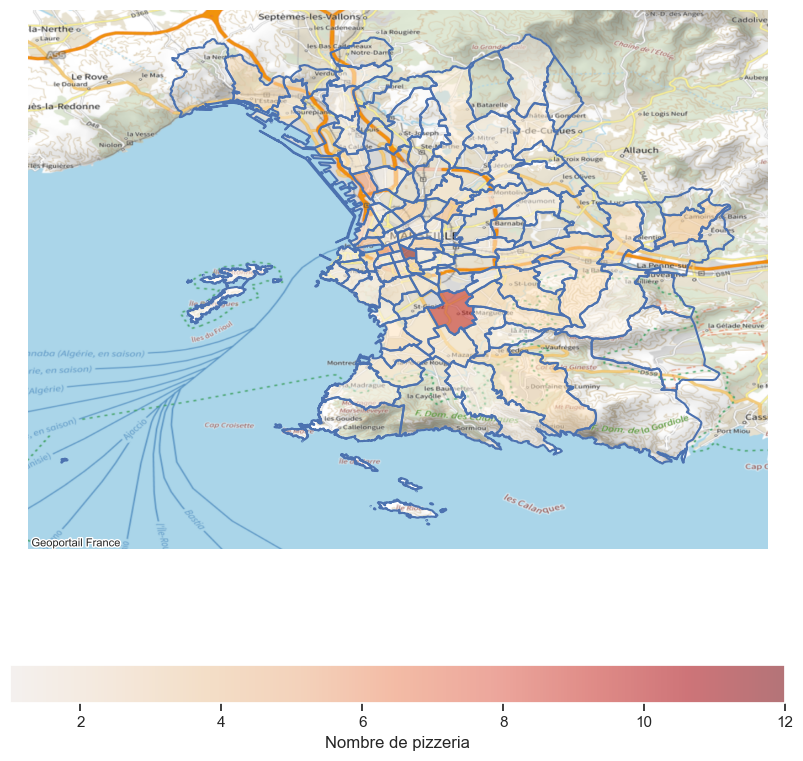

In [121]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.axis(False)

quartiers.boundary.plot(ax=ax)
quartiers_compte.plot(column='nombre', 
             legend=True,
             legend_kwds={'label': "Nombre de pizzeria", 'orientation': "horizontal"},
             cmap=cmap,
             ax=ax)
ctx.add_basemap(ax, crs="epsg:4326", source=xyz.GeoportailFrance.plan)

plt.show()